In [159]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import ZeroPadding2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import History
from keras.optimizers import Nadam, Adam, SGD
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
import pydot
import data_augmentation as da
import pre_processing as pp
import importlib
K.set_image_dim_ordering('th')

In [200]:
training = pp.get_training()
test = pp.get_test()

In [201]:
X_train = np.array([x for x, y in training])
y_train = np.array([y for x, y in training])
X_test = test
X_train = X_train.reshape(-1, 64, 64)
y_train = y_train.reshape(-1, 1)

In [202]:
pixel_count = X_train.shape[1] * X_train.shape[2]

In [203]:
y_train = np_utils.to_categorical(y_train)

In [204]:
class_count = y_train.shape[1]

In [205]:
# Seed for reproducibility
seed = 42
np.random.seed(seed)

In [206]:
# FOR CNN
X_train = X_train.reshape(X_train.shape[0], 1, 64, 64).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 64, 64).astype('float32')

In [9]:
def base_cnn():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 64, 64), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_base = base_cnn()

In [11]:
def larger_cnn():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 64, 64), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(50, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_larger = larger_cnn()

In [11]:
def larger_cnn_relu():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 64, 64), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
def deep_cnn():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='linear', input_shape=(1, 64, 64)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(512, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_deep = deep_cnn()

In [57]:
def deep_cnn_relu():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(1, 64, 64)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_deep_relu = deep_cnn_relu()

In [15]:
def deeper_cnn():
    # create model
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='linear', input_shape=(1, 64, 64)))
    model.add(Conv2D(128, kernel_size=(5, 5), strides=(1, 1), activation='linear'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(512, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_deeper = deeper_cnn()

In [16]:
def deeper_cnn_relu():
    # create model
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(1, 64, 64)))
    model.add(Conv2D(128, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
def deep_cnn_s2_k4():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), activation='relu', input_shape=(1, 64, 64)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu'))
    model.add(Conv2D(256, kernel_size=(2, 2), strides=(2, 2), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_s2_k4 = deep_cnn_s2_k4()

In [34]:
def deep_cnn_s3():
    model = Sequential()
    model.add(ZeroPadding2D(padding=(2, 2), input_shape=(1, 64, 64)))
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(3, 3), activation='relu', input_shape=(1, 64, 64)))
    model.add(Conv2D(64, kernel_size=(4, 4), strides=(3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(ZeroPadding2D(padding=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_s3 = deep_cnn_s3()

# Model Testing

## Base Model

In [14]:
cnn_model_base = base_cnn()
cnn_model_base_history = cnn_model_base.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 7s - loss: 0.5681 - acc: 0.8376 - val_loss: 0.3579 - val_acc: 0.9074
Epoch 2/50
 - 6s - loss: 0.3238 - acc: 0.9133 - val_loss: 0.3121 - val_acc: 0.9186
Epoch 3/50
 - 6s - loss: 0.2549 - acc: 0.9323 - val_loss: 0.2947 - val_acc: 0.9270
Epoch 4/50
 - 6s - loss: 0.2130 - acc: 0.9434 - val_loss: 0.2805 - val_acc: 0.9300
Epoch 5/50
 - 6s - loss: 0.1788 - acc: 0.9518 - val_loss: 0.2938 - val_acc: 0.9264
Epoch 6/50
 - 6s - loss: 0.1509 - acc: 0.9578 - val_loss: 0.2976 - val_acc: 0.9256
Epoch 7/50
 - 6s - loss: 0.1258 - acc: 0.9644 - val_loss: 0.3091 - val_acc: 0.9304
Epoch 8/50
 - 6s - loss: 0.1063 - acc: 0.9689 - val_loss: 0.3093 - val_acc: 0.9286
Epoch 9/50
 - 6s - loss: 0.0879 - acc: 0.9731 - val_loss: 0.3281 - val_acc: 0.9290
Epoch 10/50
 - 6s - loss: 0.0736 - acc: 0.9766 - val_loss: 0.3553 - val_acc: 0.9260
Epoch 11/50
 - 6s - loss: 0.0628 - acc: 0.9788 - val_loss: 0.3773 - val_acc: 0.9222
Epoch 12/50
 - 6s - loss: 0.0571 - a

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


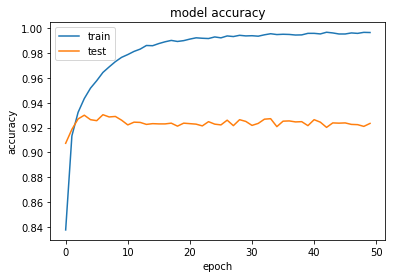

In [17]:
print(cnn_model_base_history.history.keys())
# summarize history for accuracy
plt.plot(cnn_model_base_history.history['acc'])
plt.plot(cnn_model_base_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
plot_model(cnn_model_base,to_file="cnn_model_base.png",show_shapes=True)

## Larger Model

In [19]:
cnn_model_larger_history = cnn_model_larger.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 7s - loss: 0.6803 - acc: 0.7962 - val_loss: 0.3463 - val_acc: 0.9088
Epoch 2/50
 - 7s - loss: 0.3762 - acc: 0.8992 - val_loss: 0.2875 - val_acc: 0.9280
Epoch 3/50
 - 7s - loss: 0.3142 - acc: 0.9160 - val_loss: 0.2701 - val_acc: 0.9336
Epoch 4/50
 - 7s - loss: 0.2776 - acc: 0.9271 - val_loss: 0.2587 - val_acc: 0.9356
Epoch 5/50
 - 6s - loss: 0.2562 - acc: 0.9315 - val_loss: 0.2455 - val_acc: 0.9408
Epoch 6/50
 - 6s - loss: 0.2386 - acc: 0.9356 - val_loss: 0.2434 - val_acc: 0.9416
Epoch 7/50
 - 6s - loss: 0.2205 - acc: 0.9409 - val_loss: 0.2352 - val_acc: 0.9460
Epoch 8/50
 - 6s - loss: 0.2077 - acc: 0.9443 - val_loss: 0.2428 - val_acc: 0.9414
Epoch 9/50
 - 6s - loss: 0.1965 - acc: 0.9472 - val_loss: 0.2370 - val_acc: 0.9424
Epoch 10/50
 - 6s - loss: 0.1835 - acc: 0.9502 - val_loss: 0.2354 - val_acc: 0.9456
Epoch 11/50
 - 6s - loss: 0.1777 - acc: 0.9510 - val_loss: 0.2332 - val_acc: 0.9456
Epoch 12/50
 - 6s - loss: 0.1650 - a

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


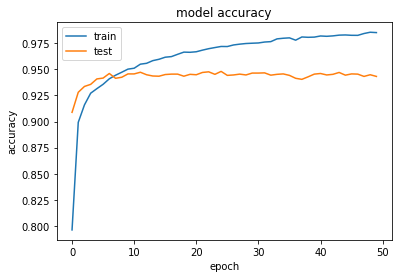

In [20]:
print(cnn_model_larger_history.history.keys())
# summarize history for accuracy
plt.plot(cnn_model_larger_history.history['acc'])
plt.plot(cnn_model_larger_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
plot_model(cnn_model_larger,to_file="cnn_model_larger.png",show_shapes=True)

## Deep Model

In [38]:
cnn_model_deep_history = cnn_model_deep.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 11s - loss: 0.0391 - acc: 0.9876 - val_loss: 0.3225 - val_acc: 0.9506
Epoch 2/50
 - 11s - loss: 0.0348 - acc: 0.9895 - val_loss: 0.3251 - val_acc: 0.9516
Epoch 3/50
 - 11s - loss: 0.0310 - acc: 0.9905 - val_loss: 0.3270 - val_acc: 0.9534
Epoch 4/50
 - 11s - loss: 0.0302 - acc: 0.9903 - val_loss: 0.3494 - val_acc: 0.9496
Epoch 5/50
 - 11s - loss: 0.0340 - acc: 0.9895 - val_loss: 0.3158 - val_acc: 0.9518
Epoch 6/50
 - 11s - loss: 0.0255 - acc: 0.9919 - val_loss: 0.3552 - val_acc: 0.9492
Epoch 7/50
 - 11s - loss: 0.0257 - acc: 0.9919 - val_loss: 0.3499 - val_acc: 0.9500
Epoch 8/50
 - 11s - loss: 0.0265 - acc: 0.9918 - val_loss: 0.3240 - val_acc: 0.9548
Epoch 9/50
 - 11s - loss: 0.0272 - acc: 0.9915 - val_loss: 0.3152 - val_acc: 0.9526
Epoch 10/50
 - 11s - loss: 0.0278 - acc: 0.9914 - val_loss: 0.3556 - val_acc: 0.9496
Epoch 11/50
 - 11s - loss: 0.0212 - acc: 0.9931 - val_loss: 0.3759 - val_acc: 0.9552
Epoch 12/50
 - 11s - loss

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


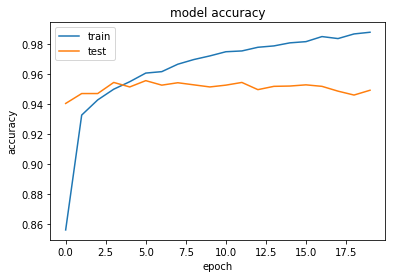

In [24]:
cnn_model_deep_history = cnn_model_deep_histroy
print(cnn_model_deep_history.history.keys())
# summarize history for accuracy
plt.plot(cnn_model_deep_history.history['acc'])
plt.plot(cnn_model_deep_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
plot_model(cnn_model_deep,to_file="cnn_model_deep.png",show_shapes=True)

## Deeper Model

In [222]:
cnn_model_deeper_history = cnn_model_deeper.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 45s - loss: 0.0275 - acc: 0.9933 - val_loss: 0.4769 - val_acc: 0.9398
Epoch 2/50
 - 45s - loss: 0.0198 - acc: 0.9952 - val_loss: 0.4719 - val_acc: 0.9412
Epoch 3/50
 - 44s - loss: 0.0172 - acc: 0.9957 - val_loss: 0.4609 - val_acc: 0.9434
Epoch 4/50
 - 44s - loss: 0.0179 - acc: 0.9957 - val_loss: 0.4486 - val_acc: 0.9448
Epoch 5/50
 - 44s - loss: 0.0164 - acc: 0.9959 - val_loss: 0.4616 - val_acc: 0.9396
Epoch 6/50
 - 44s - loss: 0.0174 - acc: 0.9959 - val_loss: 0.4887 - val_acc: 0.9430
Epoch 7/50
 - 44s - loss: 0.0268 - acc: 0.9944 - val_loss: 0.4256 - val_acc: 0.9418
Epoch 8/50
 - 44s - loss: 0.0152 - acc: 0.9959 - val_loss: 0.4548 - val_acc: 0.9438
Epoch 9/50
 - 44s - loss: 0.0168 - acc: 0.9957 - val_loss: 0.4997 - val_acc: 0.9444
Epoch 10/50
 - 44s - loss: 0.0871 - acc: 0.9841 - val_loss: 0.4866 - val_acc: 0.9384
Epoch 11/50
 - 44s - loss: 0.0355 - acc: 0.9920 - val_loss: 0.4806 - val_acc: 0.9364
Epoch 12/50
 - 44s - loss

In [ ]:
print(cnn_model_deeper_history.history.keys())
# summarize history for accuracy
plt.plot(cnn_model_deeper_history.history['acc'])
plt.plot(cnn_model_deeper_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
plot_model(cnn_model_deeper,to_file="cnn_model_deeper.png",show_shapes=True)

## S2_K4

In [39]:
cnn_s2_k4_history = cnn_s2_k4.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 5s - loss: 0.5969 - acc: 0.8245 - val_loss: 0.3026 - val_acc: 0.9220
Epoch 2/50
 - 5s - loss: 0.3144 - acc: 0.9176 - val_loss: 0.2439 - val_acc: 0.9368
Epoch 3/50
 - 5s - loss: 0.2637 - acc: 0.9322 - val_loss: 0.2357 - val_acc: 0.9406
Epoch 4/50
 - 5s - loss: 0.2366 - acc: 0.9389 - val_loss: 0.2323 - val_acc: 0.9450
Epoch 5/50
 - 5s - loss: 0.2169 - acc: 0.9440 - val_loss: 0.2180 - val_acc: 0.9462
Epoch 6/50
 - 5s - loss: 0.2034 - acc: 0.9479 - val_loss: 0.2283 - val_acc: 0.9416
Epoch 7/50
 - 5s - loss: 0.1844 - acc: 0.9519 - val_loss: 0.2235 - val_acc: 0.9438
Epoch 8/50
 - 5s - loss: 0.1762 - acc: 0.9535 - val_loss: 0.2204 - val_acc: 0.9494
Epoch 9/50
 - 5s - loss: 0.1589 - acc: 0.9580 - val_loss: 0.2208 - val_acc: 0.9492
Epoch 10/50
 - 5s - loss: 0.1481 - acc: 0.9606 - val_loss: 0.2438 - val_acc: 0.9482
Epoch 11/50
 - 5s - loss: 0.1397 - acc: 0.9623 - val_loss: 0.2357 - val_acc: 0.9484
Epoch 12/50
 - 5s - loss: 0.1313 - a

In [ ]:
print(cnn_s2_k4_history.history.keys())
# summarize history for accuracy
plt.plot(cnn_s2_k4_history.history['acc'])
plt.plot(cnn_s2_k4_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
plot_model(cnn_s2_k4,to_file="cnn_s2_k4.png",show_shapes=True)

## S3

In [40]:
cnn_s3_history = cnn_s3.fit(X_train, y_train, batch_size=128, epochs=150, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/150
 - 4s - loss: 0.9303 - acc: 0.7054 - val_loss: 0.4161 - val_acc: 0.8876
Epoch 2/150
 - 4s - loss: 0.5080 - acc: 0.8545 - val_loss: 0.3249 - val_acc: 0.9106
Epoch 3/150
 - 4s - loss: 0.4253 - acc: 0.8824 - val_loss: 0.2987 - val_acc: 0.9194
Epoch 4/150
 - 4s - loss: 0.3844 - acc: 0.8938 - val_loss: 0.2769 - val_acc: 0.9270
Epoch 5/150
 - 3s - loss: 0.3623 - acc: 0.9016 - val_loss: 0.2588 - val_acc: 0.9332
Epoch 6/150
 - 4s - loss: 0.3324 - acc: 0.9097 - val_loss: 0.2478 - val_acc: 0.9364
Epoch 7/150
 - 3s - loss: 0.3192 - acc: 0.9127 - val_loss: 0.2430 - val_acc: 0.9372
Epoch 8/150
 - 4s - loss: 0.3093 - acc: 0.9150 - val_loss: 0.2473 - val_acc: 0.9394
Epoch 9/150
 - 4s - loss: 0.3011 - acc: 0.9172 - val_loss: 0.2267 - val_acc: 0.9418
Epoch 10/150
 - 4s - loss: 0.2852 - acc: 0.9232 - val_loss: 0.2303 - val_acc: 0.9402
Epoch 11/150
 - 4s - loss: 0.2843 - acc: 0.9227 - val_loss: 0.2230 - val_acc: 0.9424
Epoch 12/150
 - 4s - loss

Epoch 97/150
 - 3s - loss: 0.1341 - acc: 0.9587 - val_loss: 0.2224 - val_acc: 0.9508
Epoch 98/150
 - 3s - loss: 0.1340 - acc: 0.9584 - val_loss: 0.2282 - val_acc: 0.9514
Epoch 99/150
 - 4s - loss: 0.1318 - acc: 0.9597 - val_loss: 0.2310 - val_acc: 0.9508
Epoch 100/150
 - 3s - loss: 0.1312 - acc: 0.9592 - val_loss: 0.2216 - val_acc: 0.9504
Epoch 101/150
 - 3s - loss: 0.1344 - acc: 0.9581 - val_loss: 0.2175 - val_acc: 0.9488
Epoch 102/150
 - 3s - loss: 0.1319 - acc: 0.9593 - val_loss: 0.2324 - val_acc: 0.9496
Epoch 103/150
 - 3s - loss: 0.1361 - acc: 0.9581 - val_loss: 0.2193 - val_acc: 0.9522
Epoch 104/150
 - 3s - loss: 0.1329 - acc: 0.9584 - val_loss: 0.2213 - val_acc: 0.9488
Epoch 105/150
 - 4s - loss: 0.1268 - acc: 0.9603 - val_loss: 0.2219 - val_acc: 0.9524
Epoch 106/150
 - 3s - loss: 0.1317 - acc: 0.9600 - val_loss: 0.2239 - val_acc: 0.9480
Epoch 107/150
 - 4s - loss: 0.1312 - acc: 0.9586 - val_loss: 0.2258 - val_acc: 0.9494
Epoch 108/150
 - 4s - loss: 0.1299 - acc: 0.9596 - val_lo

In [ ]:
print(cnn_s3_history.history.keys())
# summarize history for accuracy
plt.plot(cnn_s3_history.history['acc'])
plt.plot(cnn_s3_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
plot_model(cnn_s3,to_file="cnn_s3.png",show_shapes=True)

# Expanding on the Deep Model

In [58]:
cnn_model_deep_relu_history = cnn_model_deep_relu.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 9s - loss: 0.4829 - acc: 0.8572 - val_loss: 0.2469 - val_acc: 0.9416
Epoch 2/50
 - 8s - loss: 0.2644 - acc: 0.9322 - val_loss: 0.2238 - val_acc: 0.9478
Epoch 3/50
 - 8s - loss: 0.2233 - acc: 0.9444 - val_loss: 0.2203 - val_acc: 0.9468
Epoch 4/50
 - 8s - loss: 0.2002 - acc: 0.9502 - val_loss: 0.2055 - val_acc: 0.9510
Epoch 5/50
 - 8s - loss: 0.1786 - acc: 0.9552 - val_loss: 0.2030 - val_acc: 0.9546
Epoch 6/50
 - 8s - loss: 0.1591 - acc: 0.9602 - val_loss: 0.2157 - val_acc: 0.9532
Epoch 7/50
 - 8s - loss: 0.1434 - acc: 0.9641 - val_loss: 0.2009 - val_acc: 0.9540
Epoch 8/50
 - 8s - loss: 0.1286 - acc: 0.9670 - val_loss: 0.2224 - val_acc: 0.9538
Epoch 9/50
 - 8s - loss: 0.1167 - acc: 0.9691 - val_loss: 0.2502 - val_acc: 0.9514
Epoch 10/50
 - 8s - loss: 0.1022 - acc: 0.9718 - val_loss: 0.2422 - val_acc: 0.9544
Epoch 11/50
 - 8s - loss: 0.0944 - acc: 0.9739 - val_loss: 0.2397 - val_acc: 0.9538
Epoch 12/50
 - 8s - loss: 0.0816 - a

In [ ]:
def deep_cnn_higherdropout():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='linear', input_shape=(1, 64, 64)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.7))
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(512, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_deep_higherdropout = deep_cnn_higherdropout()

In [ ]:
cnn_model_deep_higherdropout_history = cnn_model_deep_higherdropout.fit(X_train, y_train, batch_size=128, epochs=100, verbose=2, validation_split=0.1)

In [55]:
def deep_cnn_lowerdropout():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='linear', input_shape=(1, 64, 64)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(512, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_deep_lowerdropout = deep_cnn_lowerdropout()

In [56]:
cnn_model_deep_lowerdropout_history = cnn_model_deep_lowerdropout.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 11s - loss: 0.4584 - acc: 0.8674 - val_loss: 0.2596 - val_acc: 0.9326
Epoch 2/50
 - 11s - loss: 0.2456 - acc: 0.9382 - val_loss: 0.2253 - val_acc: 0.9446
Epoch 3/50
 - 10s - loss: 0.2041 - acc: 0.9491 - val_loss: 0.2088 - val_acc: 0.9496
Epoch 4/50
 - 10s - loss: 0.1755 - acc: 0.9561 - val_loss: 0.2309 - val_acc: 0.9446
Epoch 5/50
 - 10s - loss: 0.1517 - acc: 0.9620 - val_loss: 0.2152 - val_acc: 0.9500
Epoch 6/50
 - 10s - loss: 0.1309 - acc: 0.9676 - val_loss: 0.2273 - val_acc: 0.9478
Epoch 7/50
 - 10s - loss: 0.1116 - acc: 0.9715 - val_loss: 0.2376 - val_acc: 0.9492
Epoch 8/50
 - 10s - loss: 0.0898 - acc: 0.9758 - val_loss: 0.2573 - val_acc: 0.9500
Epoch 9/50
 - 10s - loss: 0.0849 - acc: 0.9763 - val_loss: 0.2715 - val_acc: 0.9488
Epoch 10/50
 - 10s - loss: 0.0690 - acc: 0.9798 - val_loss: 0.2857 - val_acc: 0.9500
Epoch 11/50
 - 10s - loss: 0.0562 - acc: 0.9824 - val_loss: 0.3414 - val_acc: 0.9458
Epoch 12/50
 - 10s - loss

In [59]:
def deep_cnn_relu_lowerdropout():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(1, 64, 64)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_deep_relu_lowerdropout = deep_cnn_relu_lowerdropout()

In [63]:
cnn_model_deep_relu_lowerdropout_history = cnn_model_deep_relu_lowerdropout.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 9s - loss: 0.0247 - acc: 0.9918 - val_loss: 0.3754 - val_acc: 0.9504
Epoch 2/50
 - 8s - loss: 0.0209 - acc: 0.9936 - val_loss: 0.3825 - val_acc: 0.9516
Epoch 3/50
 - 8s - loss: 0.0195 - acc: 0.9939 - val_loss: 0.3637 - val_acc: 0.9462
Epoch 4/50
 - 8s - loss: 0.0220 - acc: 0.9933 - val_loss: 0.3828 - val_acc: 0.9494
Epoch 5/50
 - 8s - loss: 0.0205 - acc: 0.9939 - val_loss: 0.3854 - val_acc: 0.9504
Epoch 6/50
 - 8s - loss: 0.0178 - acc: 0.9946 - val_loss: 0.4068 - val_acc: 0.9444
Epoch 7/50
 - 8s - loss: 0.0222 - acc: 0.9933 - val_loss: 0.3683 - val_acc: 0.9468
Epoch 8/50
 - 9s - loss: 0.0167 - acc: 0.9950 - val_loss: 0.3961 - val_acc: 0.9502
Epoch 9/50
 - 8s - loss: 0.0204 - acc: 0.9941 - val_loss: 0.4170 - val_acc: 0.9478
Epoch 10/50
 - 9s - loss: 0.0178 - acc: 0.9947 - val_loss: 0.3633 - val_acc: 0.9484
Epoch 11/50
 - 9s - loss: 0.0162 - acc: 0.9953 - val_loss: 0.3998 - val_acc: 0.9486
Epoch 12/50
 - 8s - loss: 0.0164 - a

In [62]:
def deep_cnn_relu_higherdropout():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(1, 64, 64)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.7))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
cnn_model_deep_relu_higherdropout = deep_cnn_relu_higherdropout()

In [64]:
cnn_model_deep_relu_higherdropout_history = cnn_model_deep_relu_higherdropout.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
 - 9s - loss: 0.5521 - acc: 0.8350 - val_loss: 0.2605 - val_acc: 0.9356
Epoch 2/50
 - 8s - loss: 0.3079 - acc: 0.9197 - val_loss: 0.2293 - val_acc: 0.9416
Epoch 3/50
 - 8s - loss: 0.2669 - acc: 0.9315 - val_loss: 0.2150 - val_acc: 0.9476
Epoch 4/50
 - 8s - loss: 0.2413 - acc: 0.9382 - val_loss: 0.2076 - val_acc: 0.9496
Epoch 5/50
 - 8s - loss: 0.2221 - acc: 0.9430 - val_loss: 0.2018 - val_acc: 0.9526
Epoch 6/50
 - 8s - loss: 0.2059 - acc: 0.9467 - val_loss: 0.2135 - val_acc: 0.9500
Epoch 7/50
 - 8s - loss: 0.1969 - acc: 0.9493 - val_loss: 0.2011 - val_acc: 0.9544
Epoch 8/50
 - 8s - loss: 0.1815 - acc: 0.9528 - val_loss: 0.2004 - val_acc: 0.9536
Epoch 9/50
 - 8s - loss: 0.1721 - acc: 0.9555 - val_loss: 0.1981 - val_acc: 0.9536
Epoch 10/50
 - 8s - loss: 0.1606 - acc: 0.9587 - val_loss: 0.1982 - val_acc: 0.9576
Epoch 11/50
 - 8s - loss: 0.1477 - acc: 0.9607 - val_loss: 0.1982 - val_acc: 0.9566
Epoch 12/50
 - 8s - loss: 0.1438 - a

# Expanding Deep - .7 Dropout, Leaky

In [191]:
def deep_cnn_relu_sgd():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='linear', input_shape=(1, 64, 64)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.7))
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(512, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model
cnn_model_deep_relu_sgd = deep_cnn_relu_sgd()

In [192]:
cnn_model_deep_relu_sgd_history = cnn_model_deep_relu_sgd.fit(X_train, y_train, batch_size=128, epochs=100, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
 - 11s - loss: 2.1964 - acc: 0.2038 - val_loss: 1.6431 - val_acc: 0.4300
Epoch 2/100
 - 9s - loss: 1.1785 - acc: 0.6142 - val_loss: 0.7261 - val_acc: 0.7754
Epoch 3/100
 - 9s - loss: 0.7774 - acc: 0.7638 - val_loss: 0.5368 - val_acc: 0.8506
Epoch 4/100
 - 9s - loss: 0.6304 - acc: 0.8178 - val_loss: 0.4672 - val_acc: 0.8736
Epoch 5/100
 - 9s - loss: 0.5477 - acc: 0.8450 - val_loss: 0.3897 - val_acc: 0.8970
Epoch 6/100
 - 9s - loss: 0.4935 - acc: 0.8634 - val_loss: 0.3882 - val_acc: 0.8998
Epoch 7/100
 - 9s - loss: 0.4612 - acc: 0.8742 - val_loss: 0.3413 - val_acc: 0.9112
Epoch 8/100
 - 9s - loss: 0.4319 - acc: 0.8841 - val_loss: 0.3162 - val_acc: 0.9196
Epoch 9/100
 - 9s - loss: 0.4071 - acc: 0.8922 - val_loss: 0.3165 - val_acc: 0.9204
Epoch 10/100
 - 9s - loss: 0.3919 - acc: 0.8958 - val_loss: 0.2960 - val_acc: 0.9262
Epoch 11/100
 - 9s - loss: 0.3779 - acc: 0.9004 - val_loss: 0.2840 - val_acc: 0.9284
Epoch 12/100
 - 9s - los

Epoch 97/100
 - 9s - loss: 0.1617 - acc: 0.9574 - val_loss: 0.2030 - val_acc: 0.9544
Epoch 98/100
 - 10s - loss: 0.1626 - acc: 0.9572 - val_loss: 0.2102 - val_acc: 0.9548
Epoch 99/100
 - 10s - loss: 0.1638 - acc: 0.9571 - val_loss: 0.2060 - val_acc: 0.9562
Epoch 100/100
 - 10s - loss: 0.1612 - acc: 0.9571 - val_loss: 0.2052 - val_acc: 0.9556


In [193]:
def deep_cnn_relu_sgd_momentum():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='linear', input_shape=(1, 64, 64)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.7))
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(512, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['accuracy'])
    return model
cnn_model_deep_relu_sgd_momentum = deep_cnn_relu_sgd_momentum()

In [194]:
cnn_model_deep_relu_sgd_momentum_history = cnn_model_deep_relu_sgd_momentum.fit(X_train, y_train, batch_size=128, epochs=100, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
 - 11s - loss: 1.0634 - acc: 0.6481 - val_loss: 0.3647 - val_acc: 0.9022
Epoch 2/100
 - 10s - loss: 0.4250 - acc: 0.8845 - val_loss: 0.2772 - val_acc: 0.9274
Epoch 3/100
 - 10s - loss: 0.3488 - acc: 0.9066 - val_loss: 0.2514 - val_acc: 0.9388
Epoch 4/100
 - 10s - loss: 0.3114 - acc: 0.9191 - val_loss: 0.2330 - val_acc: 0.9406
Epoch 5/100
 - 9s - loss: 0.2914 - acc: 0.9246 - val_loss: 0.2235 - val_acc: 0.9476
Epoch 6/100
 - 9s - loss: 0.2718 - acc: 0.9297 - val_loss: 0.2197 - val_acc: 0.9480
Epoch 7/100
 - 9s - loss: 0.2609 - acc: 0.9328 - val_loss: 0.2102 - val_acc: 0.9490
Epoch 8/100
 - 9s - loss: 0.2454 - acc: 0.9365 - val_loss: 0.2171 - val_acc: 0.9478
Epoch 9/100
 - 9s - loss: 0.2354 - acc: 0.9394 - val_loss: 0.2092 - val_acc: 0.9502
Epoch 10/100
 - 9s - loss: 0.2270 - acc: 0.9419 - val_loss: 0.1991 - val_acc: 0.9528
Epoch 11/100
 - 9s - loss: 0.2218 - acc: 0.9430 - val_loss: 0.2070 - val_acc: 0.9524
Epoch 12/100
 - 9s - 

Epoch 97/100
 - 10s - loss: 0.0267 - acc: 0.9911 - val_loss: 0.3102 - val_acc: 0.9562
Epoch 98/100
 - 10s - loss: 0.0244 - acc: 0.9917 - val_loss: 0.3169 - val_acc: 0.9556
Epoch 99/100
 - 9s - loss: 0.0238 - acc: 0.9920 - val_loss: 0.3175 - val_acc: 0.9558
Epoch 100/100
 - 9s - loss: 0.0239 - acc: 0.9919 - val_loss: 0.3047 - val_acc: 0.9552


In [195]:
def deep_cnn_relu_sgd_momentum_nesterov():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='linear', input_shape=(1, 64, 64)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.7))
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(512, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9, nesterov=True), metrics=['accuracy'])
    return model
cnn_model_deep_relu_sgd_momentum_nesterov = deep_cnn_relu_sgd_momentum_nesterov()

In [196]:
cnn_model_deep_relu_sgd_momentum_nesterov_history = cnn_model_deep_relu_sgd_momentum_nesterov.fit(X_train, y_train, batch_size=128, epochs=100, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
 - 12s - loss: 1.0201 - acc: 0.6634 - val_loss: 0.3777 - val_acc: 0.8982
Epoch 2/100
 - 10s - loss: 0.4176 - acc: 0.8857 - val_loss: 0.2812 - val_acc: 0.9280
Epoch 3/100
 - 10s - loss: 0.3426 - acc: 0.9084 - val_loss: 0.2648 - val_acc: 0.9328
Epoch 4/100
 - 10s - loss: 0.3094 - acc: 0.9190 - val_loss: 0.2443 - val_acc: 0.9418
Epoch 5/100
 - 10s - loss: 0.2836 - acc: 0.9265 - val_loss: 0.2313 - val_acc: 0.9424
Epoch 6/100
 - 10s - loss: 0.2656 - acc: 0.9326 - val_loss: 0.2167 - val_acc: 0.9480
Epoch 7/100
 - 10s - loss: 0.2534 - acc: 0.9354 - val_loss: 0.2103 - val_acc: 0.9484
Epoch 8/100
 - 10s - loss: 0.2460 - acc: 0.9366 - val_loss: 0.2139 - val_acc: 0.9490
Epoch 9/100
 - 10s - loss: 0.2328 - acc: 0.9409 - val_loss: 0.2051 - val_acc: 0.9538
Epoch 10/100
 - 10s - loss: 0.2276 - acc: 0.9419 - val_loss: 0.2032 - val_acc: 0.9546
Epoch 11/100
 - 10s - loss: 0.2189 - acc: 0.9445 - val_loss: 0.2052 - val_acc: 0.9532
Epoch 12/100
 

Epoch 96/100
 - 10s - loss: 0.0270 - acc: 0.9907 - val_loss: 0.3043 - val_acc: 0.9576
Epoch 97/100
 - 10s - loss: 0.0264 - acc: 0.9911 - val_loss: 0.3045 - val_acc: 0.9560
Epoch 98/100
 - 10s - loss: 0.0244 - acc: 0.9911 - val_loss: 0.3056 - val_acc: 0.9576
Epoch 99/100
 - 10s - loss: 0.0244 - acc: 0.9920 - val_loss: 0.3000 - val_acc: 0.9612
Epoch 100/100
 - 10s - loss: 0.0232 - acc: 0.9923 - val_loss: 0.3045 - val_acc: 0.9588


In [197]:
def deep_cnn_relu_nadam():
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), activation='linear', input_shape=(1, 64, 64)))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.7))
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(1024, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(512, activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    model.add(Dense(class_count, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])
    return model
cnn_model_deep_relu_nadam = deep_cnn_relu_nadam()

In [207]:
cnn_model_deep_relu_nadam_history = cnn_model_deep_relu_nadam.fit(X_train, y_train, batch_size=128, epochs=100, verbose=2, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
 - 11s - loss: 14.5776 - acc: 0.0956 - val_loss: 14.4386 - val_acc: 0.1042
Epoch 2/100
 - 11s - loss: 14.5776 - acc: 0.0956 - val_loss: 14.4386 - val_acc: 0.1042
Epoch 3/100


KeyboardInterrupt: 

# Model Comparison Bar Graph

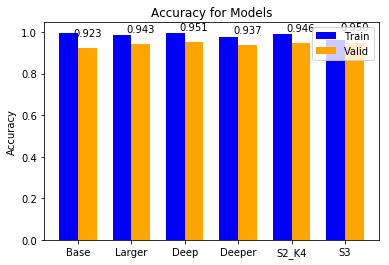

In [52]:
N = 6
valid_acc = [cnn_model_base_history.history['val_acc'][49], cnn_model_larger_history.history['val_acc'][49], 
             cnn_model_deep_history.history['val_acc'][49], cnn_model_deeper_history.history['val_acc'][19], 
             cnn_s2_k4_history.history['val_acc'][49], cnn_s3_history.history['val_acc'][149]]
train_acc = [cnn_model_base_history.history['acc'][49], cnn_model_larger_history.history['acc'][49], 
             cnn_model_deep_history.history['acc'][49], cnn_model_deeper_history.history['acc'][19], 
             cnn_s2_k4_history.history['acc'][49], cnn_s3_history.history['acc'][149]]

ind = np.arange(N)  
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, train_acc, width, color='b')
rects2 = ax.bar(ind + width, valid_acc, width, color='orange')

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for Models')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Base', 'Larger', 'Deep', 'Deeper', 'S2_K4','S3'))

ax.legend((rects1[0], rects2[0]), ('Train', 'Valid'))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rects2)

plt.show()

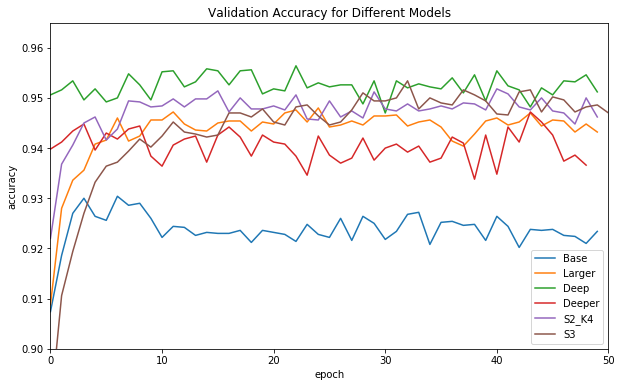

In [225]:
plt.figure(figsize=(10, 6))  
plt.axis((0,50,0.90,0.965))

plt.plot(cnn_model_base_history.history['val_acc'])
plt.plot(cnn_model_larger_history.history['val_acc'])
plt.plot(cnn_model_deep_history.history['val_acc'])
plt.plot(cnn_model_deeper_history.history['val_acc'][:49])
plt.plot(cnn_s2_k4_history.history['val_acc'])
plt.plot(cnn_s3_history.history['val_acc'])
plt.title('Validation Accuracy for Different Models')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['Base', 'Larger', 'Deep', 'Deeper', 'S2_K4', 'S3'], loc='lower right')  

plt.show()

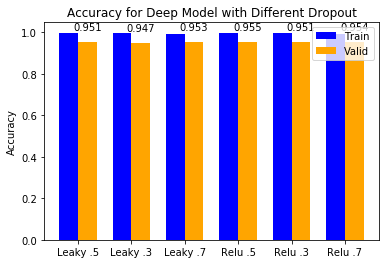

In [65]:
N = 6
valid_acc = [cnn_model_deep_history.history['val_acc'][49], cnn_model_deep_lowerdropout_history.history['val_acc'][49], 
             cnn_model_deep_higherdropout_history.history['val_acc'][49], cnn_model_deep_relu_history.history['val_acc'][49],
             cnn_model_deep_relu_lowerdropout_history.history['val_acc'][49], cnn_model_deep_relu_higherdropout_history.history['val_acc'][49]]
train_acc = [cnn_model_deep_history.history['acc'][49], cnn_model_deep_lowerdropout_history.history['acc'][49], 
             cnn_model_deep_higherdropout_history.history['acc'][49], cnn_model_deep_relu_history.history['acc'][49],
             cnn_model_deep_relu_lowerdropout_history.history['acc'][49], cnn_model_deep_relu_higherdropout_history.history['acc'][49]]

ind = np.arange(N)  
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, train_acc, width, color='b')
rects2 = ax.bar(ind + width, valid_acc, width, color='orange')

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for Deep Model with Different Dropout')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Leaky .5','Leaky .3','Leaky .7','Relu .5','Relu .3','Relu .7'))

ax.legend((rects1[0], rects2[0]), ('Train', 'Valid'))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rects2)

plt.show()

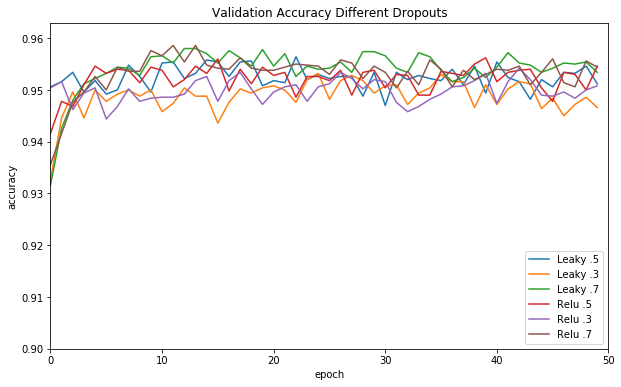

In [220]:
plt.figure(figsize=(10, 6))  
plt.axis((0,50,0.900,0.963))

plt.plot(cnn_model_deep_history.history['val_acc'])
plt.plot(cnn_model_deep_lowerdropout_history.history['val_acc'])
plt.plot(cnn_model_deep_higherdropout_history.history['val_acc'])
plt.plot(cnn_model_deep_relu_history.history['val_acc'])
plt.plot(cnn_model_deep_relu_lowerdropout_history.history['val_acc'])
plt.plot(cnn_model_deep_relu_higherdropout_history.history['val_acc'])
plt.title('Validation Accuracy Different Dropouts')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['Leaky .5','Leaky .3','Leaky .7','Relu .5','Relu .3','Relu .7'], loc='lower right')  

plt.show()

In [ ]:
N = 6
valid_acc = [cnn_model_deep_history.history['val_acc'][49], cnn_model_deep_lowerdropout_history.history['val_acc'][49], 
             cnn_model_deep_higherdropout_history.history['val_acc'][49], cnn_model_deep_relu_history.history['val_acc'][49],
             cnn_model_deep_relu_lowerdropout_history.history['val_acc'][49], cnn_model_deep_relu_higherdropout_history.history['val_acc'][49]]
train_acc = [cnn_model_deep_history.history['acc'][49], cnn_model_deep_lowerdropout_history.history['acc'][49], 
             cnn_model_deep_higherdropout_history.history['acc'][49], cnn_model_deep_relu_history.history['acc'][49],
             cnn_model_deep_relu_lowerdropout_history.history['acc'][49], cnn_model_deep_relu_higherdropout_history.history['acc'][49]]

ind = np.arange(N)  
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, train_acc, width, color='b')
rects2 = ax.bar(ind + width, valid_acc, width, color='orange')

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for Deep Model with Different Dropout')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Leaky .5','Leaky .3','Leaky .7','Relu .5','Relu .3','Relu .7'))

ax.legend((rects1[0], rects2[0]), ('Train', 'Valid'))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rects2)

plt.show()

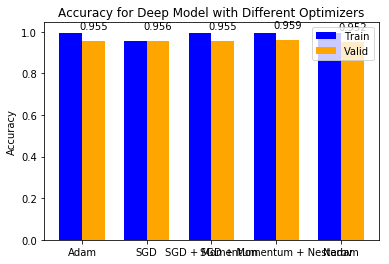

In [208]:
N = 5
valid_acc = [cnn_model_deep_relu_history.history['val_acc'][49],cnn_model_deep_relu_sgd_history.history['val_acc'][99],
            cnn_model_deep_relu_sgd_momentum_history.history['val_acc'][99],cnn_model_deep_relu_sgd_momentum_nesterov_history.history['val_acc'][99],
            cnn_model_deep_relu_nadam_history.history['val_acc'][99]]
train_acc = [cnn_model_deep_relu_history.history['acc'][49],cnn_model_deep_relu_sgd_history.history['acc'][99],
            cnn_model_deep_relu_sgd_momentum_history.history['acc'][99],cnn_model_deep_relu_sgd_momentum_nesterov_history.history['acc'][99],
            cnn_model_deep_relu_nadam_history.history['acc'][99]]

ind = np.arange(N)  
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, train_acc, width, color='b')
rects2 = ax.bar(ind + width, valid_acc, width, color='orange')

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for Deep Model with Different Optimizers')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Adam','SGD','SGD + Momentum','SGD + Momentum + Nesterov','Nadam'))

ax.legend((rects1[0], rects2[0]), ('Train', 'Valid'))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rects2)

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))  
plt.axis((0,100,0.900,0.963))

plt.plot(cnn_model_deep_relu_history.history['val_acc'])
plt.plot(cnn_model_deep_relu_sgd_history.history['val_acc'])
plt.plot(cnn_model_deep_relu_sgd_momentum_history.history['val_acc'])
plt.plot(cnn_model_deep_relu_sgd_momentum_nesterov_history.history['val_acc'])
plt.plot(cnn_model_deep_relu_nadam_history.history['val_acc'])
plt.title('Validation Accuracy Different Optimizers')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Adam','SGD','SGD + Momentum','SGD + Momentum + Nesterov','Nadam'], loc='lower right')  

plt.show()

## Fit Test Data

In [ ]:
cnn_model_deeper_relu = deeper_cnn_relu()
cnn_model_deeper_relu.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.1)

In [210]:
cnn_deep_pred = cnn_model_deep_relu_sgd_momentum_nesterov.predict(X_test)

In [211]:
cnn_deep_pred_nums = np.array([np.argmax(pred) for pred in cnn_deep_pred])

In [212]:
cnn_deep_pred_final = np.array([(i, x) for (i, x) in enumerate(cnn_deep_pred_nums)])

In [213]:
np.savetxt('../data/test_y_deep_cnn_leaky_sdgmomentumnesterov.csv', cnn_deep_pred_final, delimiter=',', fmt='%d', header='Id,Label')